In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import models
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [29]:
import pathlib
data_dir = pathlib.Path('//content/drive/MyDrive/Hand Gesture/Number Dataset')
data_dir

PosixPath('//content/drive/MyDrive/Hand Gesture/Number Dataset')

In [30]:
# Initialize counters
jpg_count = 0
png_count = 0

# Loop through files in the directory
for file_path in data_dir.glob('*/*'):
    # Check if the file is a JPG
    if file_path.suffix.lower() == ".jpg":
        jpg_count += 1
    # Check if the file is a PNG
    elif file_path.suffix.lower() == ".png":
        png_count += 1

total_image_count = jpg_count + png_count
total_image_count

380

In [31]:
finger_images_dict = {
    'One': list(data_dir.glob('One/*')),
    'Two': list(data_dir.glob('Two/*')),
    'Three': list(data_dir.glob('Three/*')),
    'Four': list(data_dir.glob('Four/*')),
    'Five': list(data_dir.glob('Five/*')),
}

In [32]:
finger_labels_dict = {
    'One': 0,
    'Two': 1,
    'Three': 2,
    'Four': 3,
    'Five': 4,
}

In [33]:
str(finger_images_dict['One'][0])

'//content/drive/MyDrive/Hand Gesture/Number Dataset/One/One.jpg'

In [34]:
img = cv2.imread(str(finger_images_dict['One'][0]))
img.shape

(1920, 1382, 3)

In [35]:
cv2.resize(img,(180,180)).shape

(180, 180, 3)

In [36]:
X, y = [], []

for finger_name, images in finger_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(180,180))
        X.append(resized_img)
        y.append(finger_labels_dict[finger_name])

In [37]:
X = np.array(X)
y = np.array(y)

In [38]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=0)

In [39]:
X_train_scaled = X_train/255
X_test_scaled = X_test/255

In [40]:
y_test[0]

1

In [41]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",
                                                 input_shape=(180,
                                                              180,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

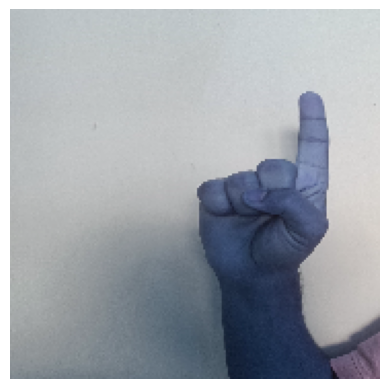

In [42]:
plt.axis('off')
plt.imshow(X[0])

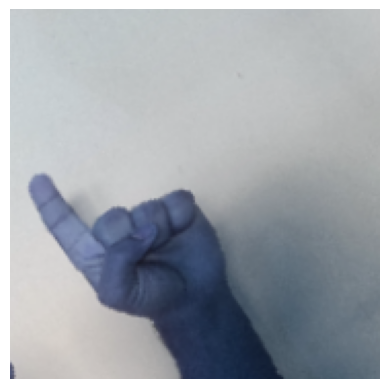

In [43]:
plt.axis('off')
plt.imshow(data_augmentation(X)[0].numpy().astype("uint8"))

In [44]:
num_classes = 5

model = Sequential([
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(X_train_scaled, y_train, epochs=50,validation_data=(X_test_scaled,y_test))

Epoch 1/50
9/9 [==============================] - 18s 2s/step - loss: 1.4357 - accuracy: 0.3614 - val_loss: 1.4329 - val_accuracy: 0.3579
Epoch 2/50
9/9 [==============================] - 10s 1s/step - loss: 1.2068 - accuracy: 0.3930 - val_loss: 1.3866 - val_accuracy: 0.3368
Epoch 3/50
9/9 [==============================] - 12s 1s/step - loss: 1.1604 - accuracy: 0.3509 - val_loss: 1.3267 - val_accuracy: 0.2842
Epoch 4/50
9/9 [==============================] - 12s 1s/step - loss: 1.1432 - accuracy: 0.3789 - val_loss: 1.2879 - val_accuracy: 0.2947
Epoch 5/50
9/9 [==============================] - 12s 1s/step - loss: 1.1325 - accuracy: 0.4211 - val_loss: 1.2756 - val_accuracy: 0.4000
Epoch 6/50
9/9 [==============================] - 12s 1s/step - loss: 1.1155 - accuracy: 0.4386 - val_loss: 1.2634 - val_accuracy: 0.4000
Epoch 7/50
9/9 [==============================] - 12s 1s/step - loss: 1.1353 - accuracy: 0.4000 - val_loss: 1.3364 - val_accuracy: 0.3684
Epoch 8/50
9/9 [==================

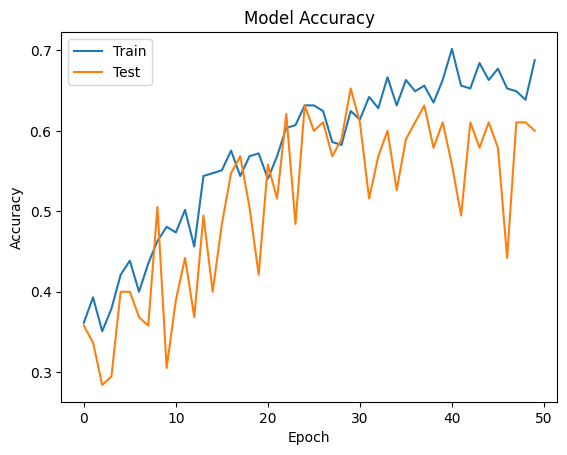

In [45]:
# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


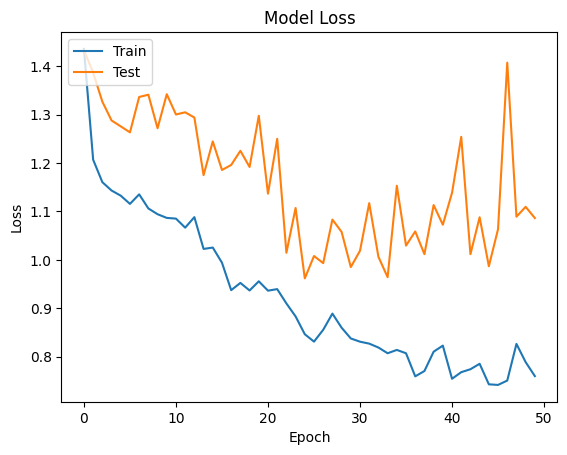

In [46]:
# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [47]:
# Evaluate the model and generate confusion matrix
y_pred_probabilities = model.predict(X_test)  # Predict class probabilities for test data
y_pred_classes = np.argmax(y_pred_probabilities, axis=1)  # Get the index of the class with the highest probability
cm = confusion_matrix(y_test, y_pred_classes)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

3/3 [==============================] - 1s 283ms/step
Confusion Matrix:
[[22  5  2  0  0]
 [ 3 13  3  0  0]
 [ 2 11 12  0  0]
 [ 2  5  7  0  0]
 [ 0  0  0  0  8]]


In [48]:
model.save('Hand_Gesture.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [49]:
model = load_model('Hand_Gesture.h5')

# ... (your data loading and preprocessing code)

def predict_with_classes(model, X_test):
  if tf.__version__.startswith('2.'):
    if int(tf.__version__.split('.')[1]) <= 5:
      return model.predict_classes(X_test)
    else:
      return np.argmax(model.predict(X_test), axis=-1)
  else:
    raise ValueError('Unsupported TensorFlow version')

y_pred = predict_with_classes(model, X_test)

# Generate classification report
print(classification_report(y_test, y_pred))

3/3 [==============================] - 1s 286ms/step
              precision    recall  f1-score   support

           0       0.76      0.76      0.76        29
           1       0.38      0.68      0.49        19
           2       0.50      0.48      0.49        25
           3       0.00      0.00      0.00        14
           4       1.00      1.00      1.00         8

    accuracy                           0.58        95
   macro avg       0.53      0.58      0.55        95
weighted avg       0.52      0.58      0.54        95



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [50]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load the model
model = load_model("/content/Hand_Gesture.h5")

# Load and preprocess the image
img = load_img("/content/drive/MyDrive/Hand Gesture/Number Dataset/One/One (10).png", target_size=(180, 180))  # Replace with your image path and target size
x = img_to_array(img)
x = x / 255.0  # Normalize
x = np.expand_dims(x, axis=0)  # Reshape for prediction

# Make prediction
predictions = model.predict(x)

# Process the predictions (depends on your model's output)
predicted_class = np.argmax(predictions[0])  # Assuming classification
print("Predicted class:", predicted_class)

1/1 [==============================] - 0s 99ms/step
Predicted class: 0


In [51]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load the pre-trained model
model = load_model('/content/Hand_Gesture.h5')  # Provide the path to your model file

def predict_image(image_path, model):
    try:
        # Load the image
        img = cv2.imread(image_path)

        # Resize the image to match the input shape expected by the model
        resized_img = cv2.resize(img, (180, 180))  # Specify input width and height

        # Normalize the image
        input_img = resized_img / 255.0

        # Add a batch dimension
        input_img = np.expand_dims(input_img, axis=0)

        # Make predictions
        predictions = model.predict(input_img)

        # Interpret predictions
        predicted_class = np.argmax(predictions)  # Get the index of the class with highest probability

        return predicted_class

    except Exception as e:
        print(f"An error occurred during prediction: {e}")
        return None

# Example usage
image_path = '/content/drive/MyDrive/Hand Gesture/Number Dataset/Five/IMG20240421170411.jpg'  # Provide the path to your image file
predicted_class = predict_image(image_path, model)

if predicted_class is not None:
    print("Predicted class:", predicted_class)
else:
    print("Failed to make a prediction.")


1/1 [==============================] - 0s 156ms/step
Predicted class: 4


In [54]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load the pre-trained model
model = load_model('/content/Hand_Gesture.h5')  # Provide the path to your model file

# Define class labels
class_labels = {0: 'One', 1: 'Two', 2: 'Three', 3:'Four', 4:'Five'}  # Update with your own labels

def predict_image(image_path, model, class_labels):
    try:
        # Load the image
        img = cv2.imread(image_path)

        # Resize the image to match the input shape expected by the model
        resized_img = cv2.resize(img, (180, 180))  # Specify input width and height

        # Normalize the image
        input_img = resized_img / 255.0

        # Add a batch dimension
        input_img = np.expand_dims(input_img, axis=0)

        # Make predictions
        predictions = model.predict(input_img)

        # Interpret predictions
        predicted_class = np.argmax(predictions)  # Get the index of the class with highest probability
        predicted_label = class_labels.get(predicted_class, "Unknown")

        return predicted_label

    except Exception as e:
        print(f"An error occurred during prediction: {e}")
        return None

# Example usage
image_path = '/content/drive/MyDrive/Hand Gesture/Number Dataset/Five/IMG20240421170411.jpg'  # Provide the path to your image file
predicted_label = predict_image(image_path, model, class_labels)

if predicted_label is not None:
    print("Predicted label:", predicted_label)
else:
    print("Failed to make a prediction.")


1/1 [==============================] - 0s 319ms/step
Predicted label: Five
